# regression example - house price dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import dill
import numpy as np
import pandas as pd
import databricks.koalas as ks
from pandas.testing import assert_frame_equal
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from hyperopt import hp
from hyperopt import tpe
from sklearn.metrics import r2_score

In [4]:
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set('spark.executor.memory', '2g')
SparkContext(conf=conf)
ks.set_option('compute.default_index_type', 'distributed-sequence')

21/09/30 09:47:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/09/30 09:47:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
from gators.util import util
# sampling
from gators.sampling import UnsupervisedSampling
# frame converter
from gators.converter import KoalasToPandas
# data cleaninng
from gators.data_cleaning import (
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns,
)
# imputers
from gators.imputers import IntImputer, ObjectImputer
# encoders
from gators.encoders import (
    WOEEncoder, 
    TargetEncoder,
    RegressionEncoder, 
)
# binning
from gators.binning import BinRareEvents
# feature generation
from gators.feature_generation import (
    ClusterStatistics,
    PolynomialFeatures,
)
# feature selection
from gators.feature_selection import (
    InformationValue,
    SelectFromModel,
)
# model building
from gators.model_building (
    TrainTestSplit,
    HyperOpt,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
    LGBMTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

## offline pipeline - feature selection

In [6]:
model = LGBMRegressor(
    random_state=0, n_estimators=100, max_depth=3)
k=25
polynomial_columns = ['GrLivArea', 'OverallQual','BsmtFinSF1',
                      'LotArea','TotalBsmtSF']
offline_steps = [
    BinRareEvents(min_ratio=0.2),
    ObjectImputer(strategy='constant', value='MISSING'),
    OrdinalEncoder(),
    IntImputer(strategy='constant', value=0),
    PolynomialFeatures(
        degree=2, 
        columns=polynomial_columns,
        interaction_only=True),
    SelectFromModel(model=model, k=k),
]

### pandas

In [7]:
data = pd.read_parquet('data/house_prices.parquet').reset_index(drop=True)
y = data['SalePrice']
y = y.astype(float)
X = data.drop('SalePrice', axis=1)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

In [8]:
# target analysis
pd.DataFrame(y_train.describe()).T

,count,mean,std,min,25%,50%,75%,max
SalePrice,1022.0,181713.254403,79854.663341,34900.0,130000.0,163745.0,214975.0,755000.0


In [9]:
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train, y_train)
X_train_prepro_np = offline_pipe.transform_numpy(X_train.to_numpy())

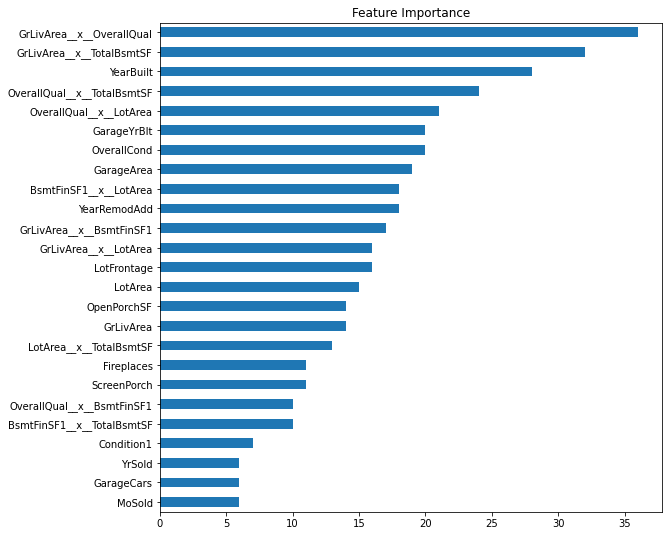

In [10]:
offline_pipe.get_feature_importances(k=k).iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Feature Importance',
);

### koalas

In [11]:
data = ks.read_parquet('data/house_prices.parquet', index_col='Id')
y_ks = data['SalePrice']
y_ks = y_ks.astype(float)
X_ks = data.drop('SalePrice', axis=1)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_ks, X_test_ks, y_train_ks, y_test_ks = \
    train_test_split.transform(X_ks, y_ks)

offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro_ks = offline_pipe.fit_transform(X_train_ks, y_train_ks)
X_train_prepro_ks_np = offline_pipe.transform_numpy(X_train_ks.to_numpy())

21/09/30 09:47:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


#### check pandas and koalas results match - offline pipeline 

In [12]:
assert_frame_equal(
    X_train_prepro.reset_index(drop=True), 
    X_train_prepro_ks.to_pandas()
)
assert np.allclose(
    X_train_prepro_np,
    X_train_prepro_ks_np)

## production pipeline

In [13]:
features = offline_pipe.get_features()
prod_columns = offline_pipe.get_production_columns()

In [14]:
prod_steps = [
    BinRareEvents(min_ratio=0.2),
    ObjectImputer(strategy='constant', value='MISSING'),
    OrdinalEncoder(),
    IntImputer(strategy='constant', value=0),
    FloatImputer(strategy='mean'),
    PolynomialFeatures(
        degree=2, 
        columns=polynomial_columns,
        interaction_only=True),
    KeepColumns(columns_to_keep=features),
]

### pandas

In [15]:
X_train_prod = X_train[prod_columns]
X_train_prod_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod, y_train)
X_train_prod_prepro = prod_pipe.transform(X_train_prod)
X_train_prod_prepro_np = prod_pipe.transform_numpy(
    X_train_prod.to_numpy())

### koalas

In [16]:
X_train_prod_ks = X_train_ks[prod_columns]
X_train_prod_ks_np = X_train_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod_ks, y_train_ks)
X_train_prod_prepro_ks = prod_pipe.transform(X_train_prod_ks)
X_train_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_train_prod_ks.to_numpy())

#### check offline pipeline and production pipeline match

In [17]:
assert_frame_equal(
    X_train_prepro, 
    X_train_prod_prepro
)
assert_frame_equal(
    X_train_prepro_ks.to_pandas(), 
    X_train_prod_prepro_ks.to_pandas()
)

#### check pandas and koalas results match - production pipeline

In [18]:
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)
assert_frame_equal(
    X_train_prod_prepro, 
    X_train_prod_prepro_ks.to_pandas()
)
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)

## model building

### numpy

In [19]:
features = list(X_train_prod_prepro.columns)
n_splits = 10
max_evals = 10
kfold = KFold(n_splits=n_splits)
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 100, 10),
    'max_depth': hp.quniform('max_depth', 2, 5, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1),
 }

model = LGBMRegressor(
    random_state=0
)
hyper = HyperOpt(
    model=model,
    algo=tpe.suggest,
    scoring='r2',
    space=space,
    max_evals=max_evals, 
    kfold=kfold,
    features=features,
    )
_ = hyper.fit(X_train_prod_prepro_np, y_train.to_numpy())

100%|████████| 10/10 [00:06<00:00,  1.53trial/s, best loss: -0.8671634162836671]


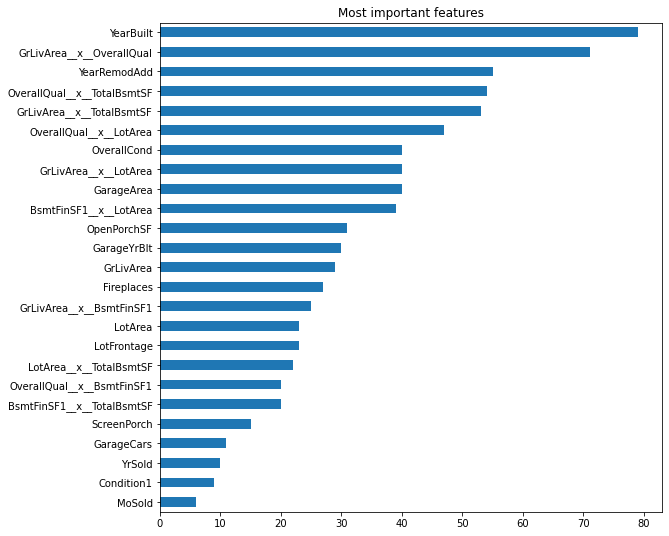

In [20]:
hyper.get_feature_importances().iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Most important features',
);

In [21]:
hyper.history.sort_values('loss')

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,loss,status,id
6,0.733368,0.076602,4.0,100.0,0.935267,-0.867163,ok,6
4,0.927167,0.065564,3.0,90.0,0.658968,-0.866158,ok,4
2,0.705010,0.134891,5.0,100.0,0.703349,-0.855558,ok,2
1,0.943498,0.170913,4.0,80.0,0.812386,-0.853450,ok,1
9,0.779439,0.716896,4.0,90.0,0.636822,-0.816832,ok,9
5,0.672439,0.028091,4.0,60.0,0.693006,-0.815979,ok,5
0,0.833365,0.017917,5.0,80.0,0.794419,-0.798830,ok,0
7,0.695419,0.016931,3.0,90.0,0.986852,-0.785819,ok,7
3,0.696185,0.017551,3.0,50.0,0.811477,-0.659360,ok,3
8,0.621090,0.007723,4.0,80.0,0.804196,-0.574611,ok,8


In [22]:
model_np = copy.copy(hyper.model)
model_path = 'models/model_lgbm_house.dill'
with open(model_path, 'wb') as file:
    dill.dump(model_np, file)

### pandas

In [23]:
model_pd = copy.copy(model_np)
_ = model_pd.fit(X_train_prod_prepro, y_train)

### treelite

In [24]:
LGBMTreeliteDumper().dump(
    model=model_np, 
    toolchain='gcc',
    parallel_comp=4,
    model_path='./models/', 
    model_name='treelite_lgbm_house')

[09:48:39] ../src/compiler/ast/split.cc:31: Parallel compilation enabled; member trees will be divided into 4 translation units.
[09:48:40] ../src/compiler/ast_native.cc:45: Using ASTNativeCompiler
[09:48:40] ../src/compiler/ast/split.cc:31: Parallel compilation enabled; member trees will be divided into 4 translation units.
[09:48:40] ../src/c_api/c_api.cc:121: Code generation finished. Writing code to files...
[09:48:40] ../src/c_api/c_api.cc:126: Writing file recipe.json...
[09:48:40] ../src/c_api/c_api.cc:126: Writing file tu3.c...
[09:48:40] ../src/c_api/c_api.cc:126: Writing file tu2.c...
[09:48:40] ../src/c_api/c_api.cc:126: Writing file tu1.c...
[09:48:40] ../src/c_api/c_api.cc:126: Writing file tu0.c...
[09:48:40] ../src/c_api/c_api.cc:126: Writing file header.h...
[09:48:40] ../src/c_api/c_api.cc:126: Writing file main.c...


In [25]:
import treelite_runtime
model_tl = treelite_runtime.Predictor(
    './models/treelite_lgbm_house.so', verbose=False)

#### check the models prediction match

In [26]:
X_test_np = X_test.to_numpy()
y_pred_pd = model_pd.predict(
    prod_pipe.transform(X_train_prod))
y_pred_np = model.predict(
    prod_pipe.transform_numpy(X_train_prod_np.copy()))
y_pred_tl = model_tl.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_train_prod_np.copy()
        )
    )
)
assert np.allclose(y_pred_np, y_pred_pd)
assert np.allclose(y_pred_np, y_pred_tl)

## model evaluation

In [27]:
X_test_prod = X_test[prod_columns]
X_test_prod_np = X_test_prod.to_numpy()
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'R2 score: {r2_score(y_test, y_test_pred):.2f}'

'R2 score: 0.85'

## per-sample bechmarking

### pipeline only

In [28]:
x = X_test_prod.iloc[[1]]
xnp = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(xnp.copy())

20.2 ms ± 734 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.1 µs ± 1.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x429'

### pipeline & model

In [30]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_np = %timeit -o model.predict(prod_pipe.transform_numpy(xnp.copy()))[0]
stats_tl = %timeit -o  model_tl.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(xnp.copy())))

33 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
263 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
96.9 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x125'

In [32]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'

'Speed-up Pandas VS Numpy&Treelite x341'